In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent
)

2022-11-10 01:24:17.916596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 01:24:17.916618: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# MotionSense Loader
loader = KuHar_BalancedView20HzMotionSenseEquivalent(
    root_dir="../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced KuHar View Resampled to 20Hz

This is a view from [KuHar v5](https://data.mendeley.com/datasets/45f952y38r/5) that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: stair down (485 train, 34 validation, 41 test) 
- 1: stair up (485 train, 34 validation, 41 test) 
- 2: sit (485 train, 34 validation, 41 test) 
- 3: stand (485 train, 34 validation, 41 test) 
- 4: walk (485 train, 34 validation, 41 test) 
- 5: run (485 train, 34 validation, 41 test) 
 

## Standartized activity codes
- 0: sit (485 train, 34 validation, 41 test) 
- 1: stand (485 train, 34 validation, 41 test) 
- 2: walk (485 train, 34 validation, 41 test) 
- 3: stair up (485 train, 34 validation, 41 test) 
- 4: stair down (485 train, 34 validation, 41 test) 
- 5: run (485 train, 34 validation, 41 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=246, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 360) (3114,) (246, 360) (246,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
# validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
# print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3114, 180)
(246, 180)


In [13]:
print(np.max(train_dataset_fft.X))

1199.4899017510002


In [14]:
train_dataset_fft.X

array([[ 5.02447148,  1.61251322,  6.76232259, ...,  0.61856338,
         1.44669533,  0.76661466],
       [ 3.57299732, 10.83009996, 11.81552738, ...,  0.33707892,
         0.57328104,  1.73237447],
       [18.92428589, 22.85409918, 26.51434407, ...,  1.28323215,
         0.74769824,  1.31400771],
       ...,
       [37.2112309 , 19.57891073, 22.52651437, ...,  1.15467725,
         1.07398967,  3.41019869],
       [58.00138092, 13.80286188, 11.50619146, ...,  1.93344645,
         6.26234023,  2.55844602],
       [22.52434513, 15.52963032,  4.92321122, ...,  5.31483603,
         3.63845394,  1.15570768]])

In [15]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [16]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 180) (3114,) (246, 180) (246,)


# Visualization helper

In [17]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [18]:
# Variables to reuse
model_dim = 10
model_epc = 125

# Reducing with Generic Autoencoders

In [19]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:416.5021, Loss-ae:416.5021, Loss-topo:130.5911
Epoch:2, P:None, Loss:339.9788, Loss-ae:339.9788, Loss-topo:108.6776
Epoch:3, P:None, Loss:254.7264, Loss-ae:254.7264, Loss-topo:576.7911
Epoch:4, P:None, Loss:234.7386, Loss-ae:234.7386, Loss-topo:467.7239
Epoch:5, P:None, Loss:210.3526, Loss-ae:210.3526, Loss-topo:533.5457
Epoch:6, P:None, Loss:195.9559, Loss-ae:195.9559, Loss-topo:848.9780
Epoch:7, P:None, Loss:185.8317, Loss-ae:185.8317, Loss-topo:1091.4599
Epoch:8, P:None, Loss:167.5632, Loss-ae:167.5632, Loss-topo:1107.2179
Epoch:9, P:None, Loss:165.9030, Loss-ae:165.9030, Loss-topo:1143.0866
Epoch:10, P:None, Loss:162.6549, Loss-ae:162.6549, Loss-topo:1340.6019
Epoch:11, P:None, Loss:160.0380, Loss-ae:160.0380, Loss-topo:1692.9934
Epoch:12, P:None, Loss:156.9095, Loss-ae:156.9095, Loss-topo:1860.6865
Epoch:13, P:None, Loss:155.1135, Loss-ae:155.1135, Loss-topo:2679.7152
Epoch:14, P:None, Loss:142.8613, Loss-ae:142.8613, Loss-topo:2799.4423
Epoch:15, P:None, Los

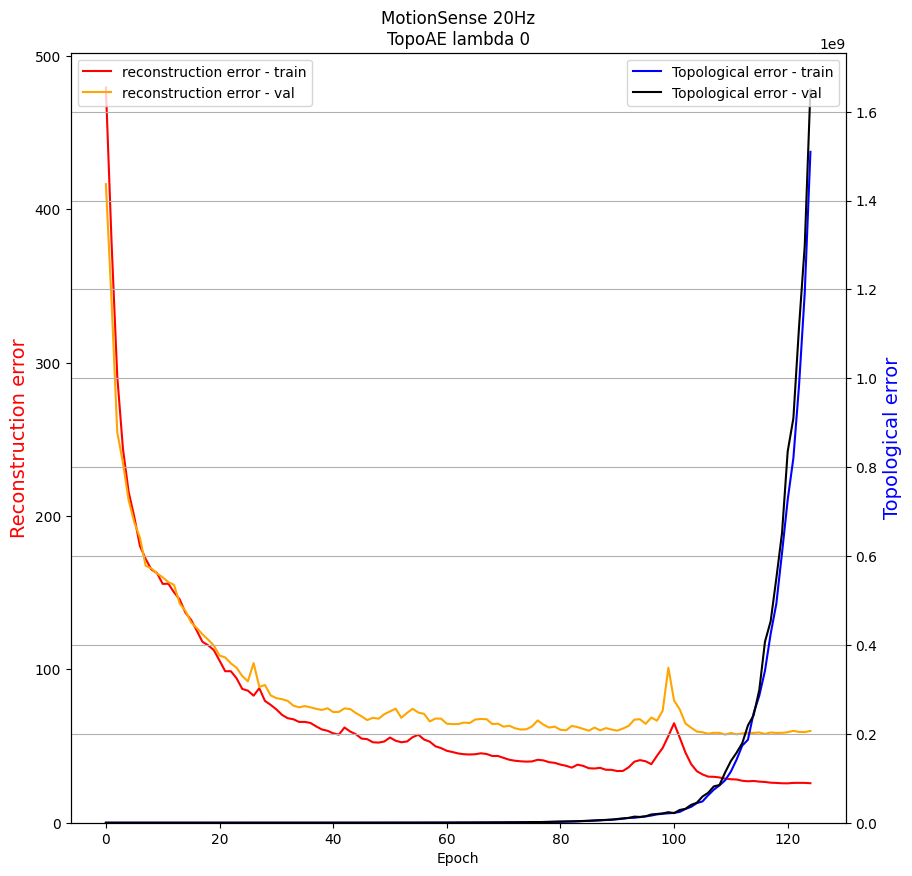

In [20]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [21]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [22]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [23]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8178861788617887,
 'RF-F1': 0.8151316013367536,
 'SVC-ACC': 0.6829268292682927,
 'SVC-F1': 0.7355481524126594,
 'KNN-ACC': 0.8211382113821138,
 'KNN-F1': 0.8183813829552535}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


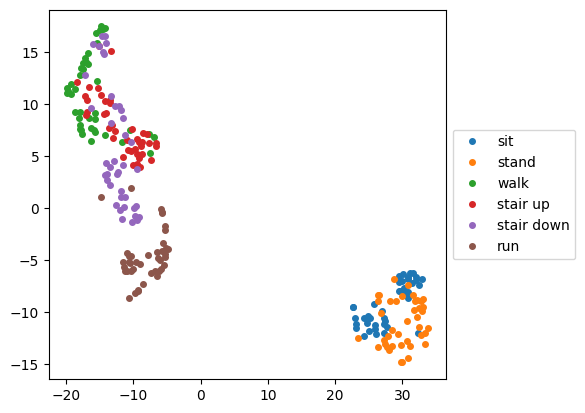

In [24]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [25]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:392.5506, Loss-ae:383.1121, Loss-topo:9.4385
Epoch:2, P:None, Loss:350.6908, Loss-ae:345.4200, Loss-topo:5.2707
Epoch:3, P:None, Loss:344.3539, Loss-ae:341.9483, Loss-topo:2.4056
Epoch:4, P:None, Loss:334.3666, Loss-ae:332.4317, Loss-topo:1.9348
Epoch:5, P:None, Loss:334.2797, Loss-ae:332.7230, Loss-topo:1.5567
Epoch:6, P:None, Loss:329.0764, Loss-ae:327.5963, Loss-topo:1.4801
Epoch:7, P:None, Loss:257.9667, Loss-ae:252.4524, Loss-topo:5.5143
Epoch:8, P:None, Loss:243.4848, Loss-ae:239.9242, Loss-topo:3.5606
Epoch:9, P:None, Loss:230.3015, Loss-ae:227.1975, Loss-topo:3.1039
Epoch:10, P:None, Loss:217.2026, Loss-ae:213.6286, Loss-topo:3.5740
Epoch:11, P:None, Loss:202.1566, Loss-ae:199.5642, Loss-topo:2.5925
Epoch:12, P:None, Loss:190.4416, Loss-ae:187.5717, Loss-topo:2.8699
Epoch:13, P:None, Loss:184.0825, Loss-ae:181.4428, Loss-topo:2.6397
Epoch:14, P:None, Loss:176.5597, Loss-ae:174.2523, Loss-topo:2.3074
Epoch:15, P:None, Loss:178.4214, Loss-ae:175.7152, Loss-t

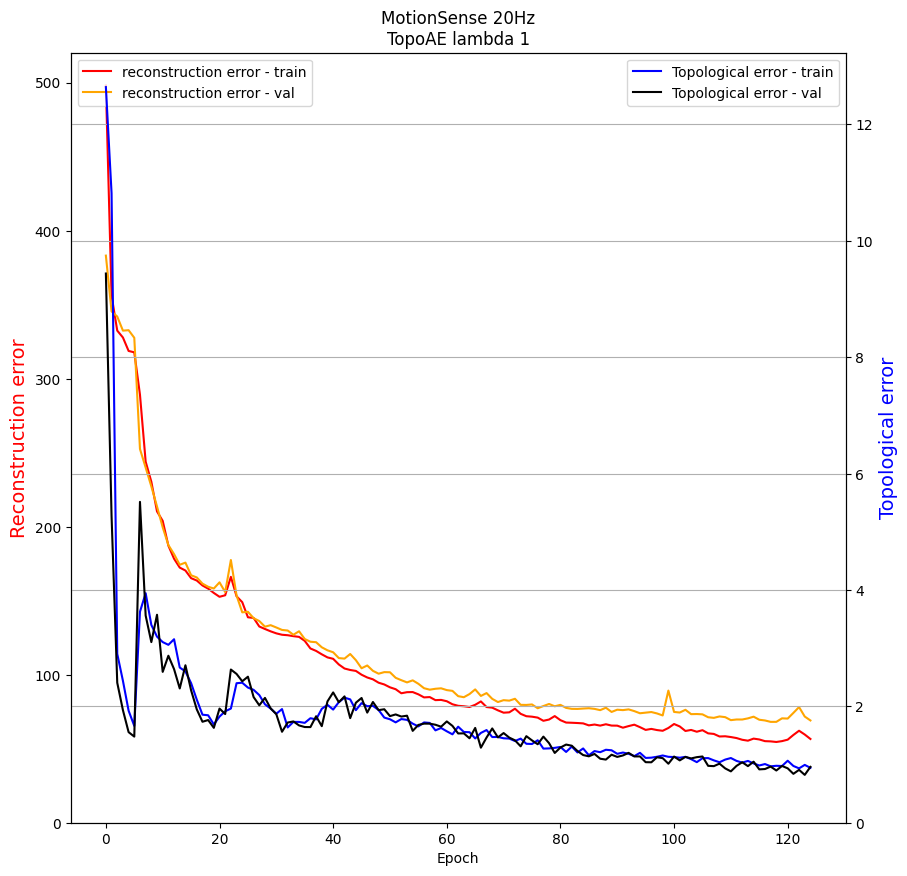

In [26]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [27]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [28]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [29]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8093495934959348,
 'RF-F1': 0.8074453452558471,
 'SVC-ACC': 0.7073170731707317,
 'SVC-F1': 0.715421759632697,
 'KNN-ACC': 0.7276422764227642,
 'KNN-F1': 0.7242404221775948}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


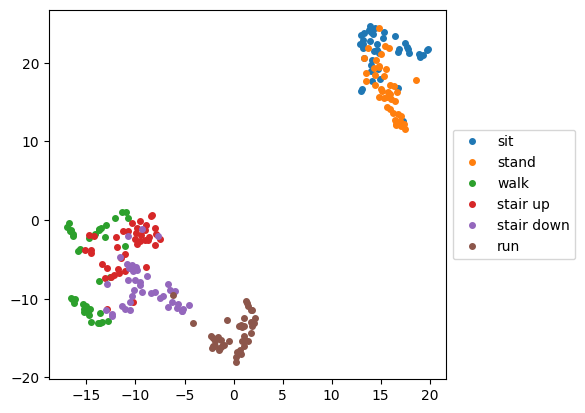

In [30]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [31]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:440.7512, Loss-ae:434.6045, Loss-topo:1.2293
Epoch:2, P:None, Loss:362.5829, Loss-ae:355.2785, Loss-topo:1.4609
Epoch:3, P:None, Loss:335.6334, Loss-ae:332.4093, Loss-topo:0.6448
Epoch:4, P:None, Loss:332.3866, Loss-ae:329.9782, Loss-topo:0.4817
Epoch:5, P:None, Loss:325.9502, Loss-ae:323.8499, Loss-topo:0.4201
Epoch:6, P:None, Loss:268.4077, Loss-ae:260.1298, Loss-topo:1.6556
Epoch:7, P:None, Loss:240.2309, Loss-ae:237.0662, Loss-topo:0.6329
Epoch:8, P:None, Loss:226.6369, Loss-ae:223.7946, Loss-topo:0.5685
Epoch:9, P:None, Loss:215.3755, Loss-ae:212.5993, Loss-topo:0.5552
Epoch:10, P:None, Loss:208.4299, Loss-ae:205.5874, Loss-topo:0.5685
Epoch:11, P:None, Loss:205.4113, Loss-ae:202.9155, Loss-topo:0.4992
Epoch:12, P:None, Loss:191.8926, Loss-ae:189.6513, Loss-topo:0.4483
Epoch:13, P:None, Loss:193.9372, Loss-ae:191.0204, Loss-topo:0.5833
Epoch:14, P:None, Loss:180.4922, Loss-ae:178.0126, Loss-topo:0.4959
Epoch:15, P:None, Loss:173.4287, Loss-ae:170.6865, Loss-t

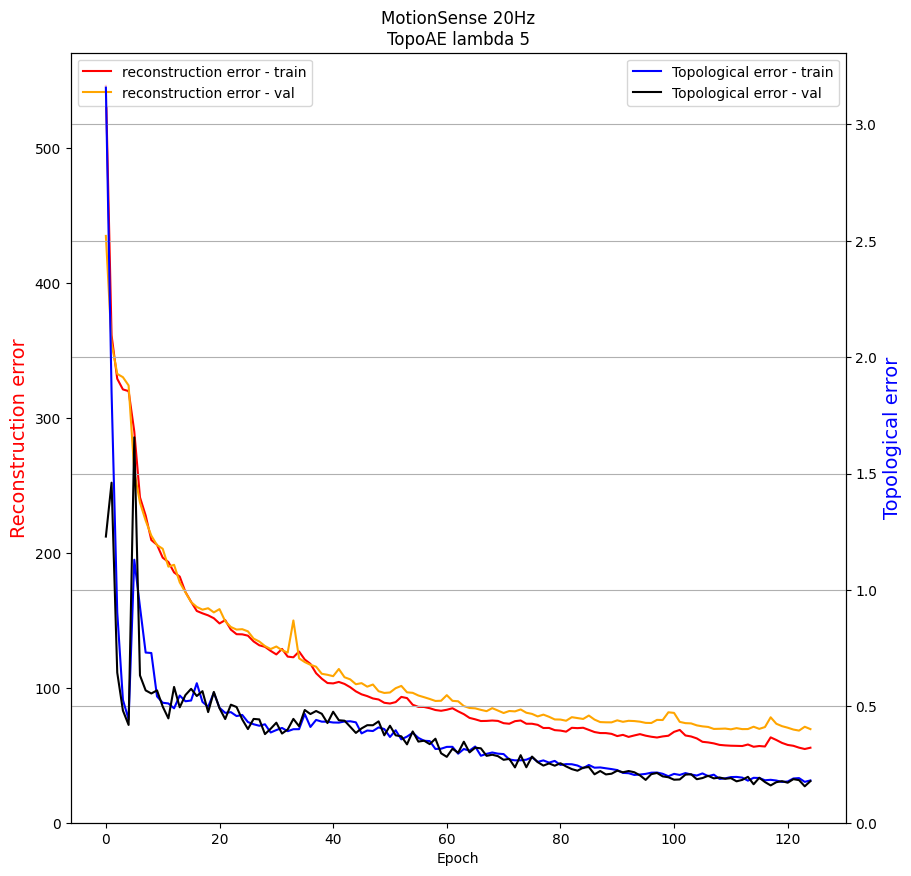

In [32]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [33]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [34]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [35]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7963414634146342,
 'RF-F1': 0.7965152450519115,
 'SVC-ACC': 0.7804878048780488,
 'SVC-F1': 0.7793901191485313,
 'KNN-ACC': 0.7357723577235772,
 'KNN-F1': 0.7347190047704818}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


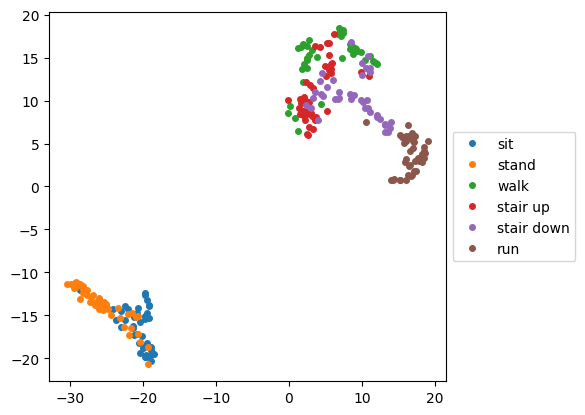

In [36]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [37]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:432.0157, Loss-ae:393.4732, Loss-topo:3.8542
Epoch:2, P:None, Loss:341.3080, Loss-ae:336.4720, Loss-topo:0.4836
Epoch:3, P:None, Loss:341.2801, Loss-ae:338.2334, Loss-topo:0.3047
Epoch:4, P:None, Loss:332.8407, Loss-ae:331.0791, Loss-topo:0.1762
Epoch:5, P:None, Loss:325.8413, Loss-ae:324.8467, Loss-topo:0.0995
Epoch:6, P:None, Loss:311.2315, Loss-ae:307.8475, Loss-topo:0.3384
Epoch:7, P:None, Loss:251.3126, Loss-ae:246.5457, Loss-topo:0.4767
Epoch:8, P:None, Loss:235.2371, Loss-ae:231.7337, Loss-topo:0.3503
Epoch:9, P:None, Loss:222.5380, Loss-ae:218.0479, Loss-topo:0.4490
Epoch:10, P:None, Loss:216.6434, Loss-ae:212.9103, Loss-topo:0.3733
Epoch:11, P:None, Loss:210.8360, Loss-ae:208.0840, Loss-topo:0.2752
Epoch:12, P:None, Loss:204.5273, Loss-ae:201.9842, Loss-topo:0.2543
Epoch:13, P:None, Loss:197.3595, Loss-ae:195.4553, Loss-topo:0.1904
Epoch:14, P:None, Loss:181.4219, Loss-ae:179.3484, Loss-topo:0.2073
Epoch:15, P:None, Loss:174.8694, Loss-ae:172.4894, Loss-t

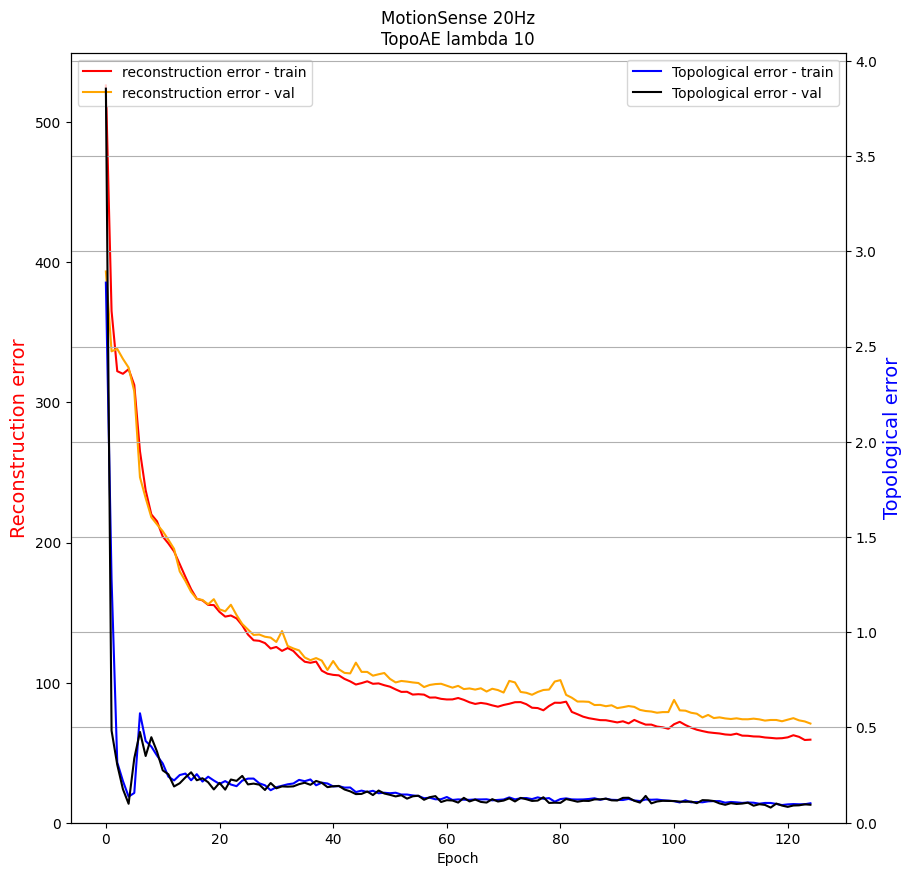

In [38]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [39]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [40]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [41]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.744308943089431,
 'RF-F1': 0.7470598061357256,
 'SVC-ACC': 0.6300813008130082,
 'SVC-F1': 0.6857166664242671,
 'KNN-ACC': 0.7113821138211383,
 'KNN-F1': 0.7096230079441651}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


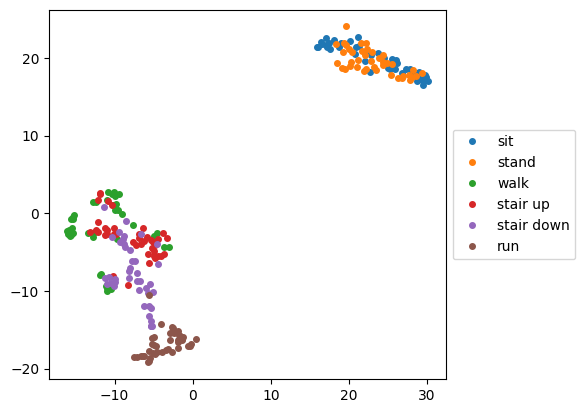

In [42]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [43]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:502.1908, Loss-ae:481.0551, Loss-topo:0.2114
Epoch:2, P:None, Loss:370.6124, Loss-ae:360.6957, Loss-topo:0.0992
Epoch:3, P:None, Loss:341.1312, Loss-ae:334.3264, Loss-topo:0.0680
Epoch:4, P:None, Loss:329.7131, Loss-ae:325.7788, Loss-topo:0.0393
Epoch:5, P:None, Loss:330.3944, Loss-ae:327.5786, Loss-topo:0.0282
Epoch:6, P:None, Loss:325.3207, Loss-ae:324.1255, Loss-topo:0.0120
Epoch:7, P:None, Loss:316.3594, Loss-ae:315.3093, Loss-topo:0.0105
Epoch:8, P:None, Loss:280.6490, Loss-ae:273.9522, Loss-topo:0.0670
Epoch:9, P:None, Loss:251.3196, Loss-ae:248.2315, Loss-topo:0.0309
Epoch:10, P:None, Loss:246.1616, Loss-ae:242.5469, Loss-topo:0.0361
Epoch:11, P:None, Loss:239.4575, Loss-ae:237.1603, Loss-topo:0.0230
Epoch:12, P:None, Loss:237.6722, Loss-ae:236.0346, Loss-topo:0.0164
Epoch:13, P:None, Loss:222.7469, Loss-ae:220.1925, Loss-topo:0.0255
Epoch:14, P:None, Loss:211.8611, Loss-ae:209.6873, Loss-topo:0.0217
Epoch:15, P:None, Loss:200.6425, Loss-ae:198.7860, Loss-t

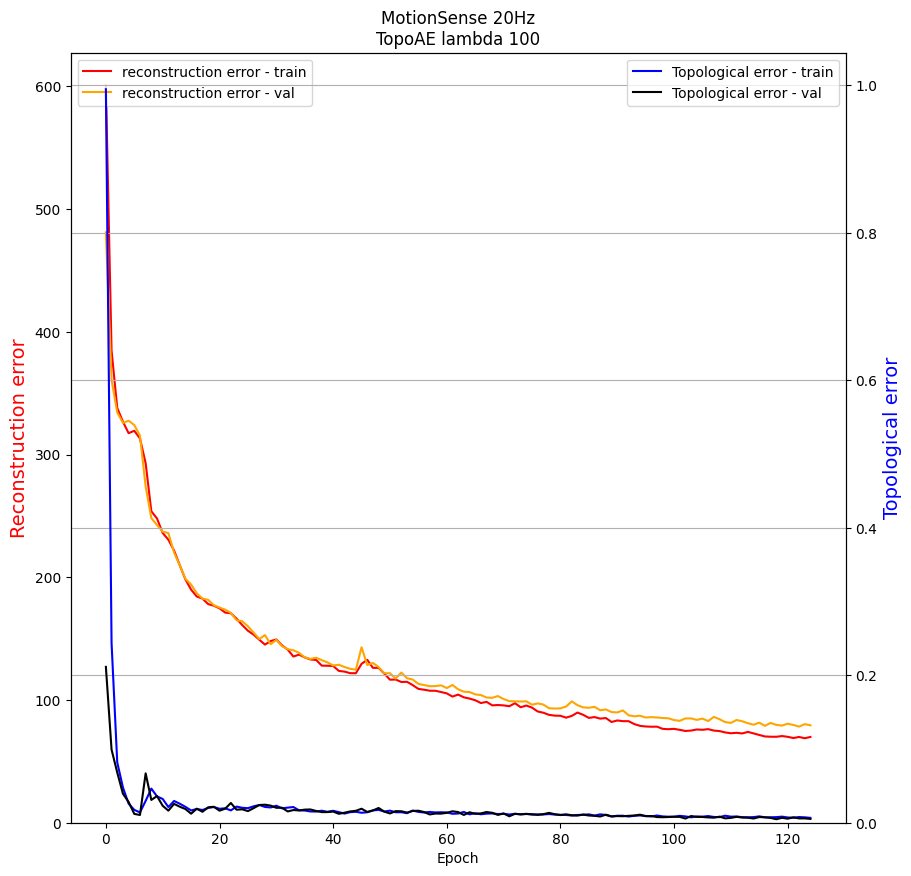

In [44]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [45]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [46]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [47]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7739837398373984,
 'RF-F1': 0.7731859589520899,
 'SVC-ACC': 0.7154471544715447,
 'SVC-F1': 0.7140474276268748,
 'KNN-ACC': 0.7601626016260162,
 'KNN-F1': 0.7575323431069266}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


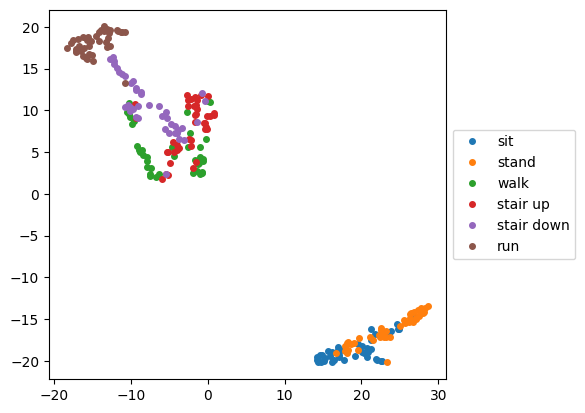

In [48]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [49]:
# Reducing with Convolutional Topological Autoencoders

In [50]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [51]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [52]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [53]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [54]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result